In [1]:
# 1. IMPORTS
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 2. PATHS
RIPE_DIR = "data/ripe/"
UNRIPE_DIR = "data/unripe/"
MODEL_SAVE_PATH = "models/ripeness_classifier_v1.h5" #rename the model aron dili mag duplicate

In [3]:
# 3. FEATURE EXTRACTION
def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)
    mfcc_var = np.var(mfccs, axis=1)
    features = {
        **{f'mfcc_mean_{i+1}': mfcc_mean[i] for i in range(13)},
        **{f'mfcc_var_{i+1}': mfcc_var[i] for i in range(13)},
        'zcr': np.mean(librosa.feature.zero_crossing_rate(y)),
        'rms': np.mean(librosa.feature.rms(y=y)),
        'centroid': np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
    }
    return features

def build_dataset(ripe_dir, unripe_dir):
    features, labels = [], []
    for f in os.listdir(ripe_dir):
        if f.endswith('.wav'):
            feat = extract_features(os.path.join(ripe_dir, f))
            features.append(feat)
            labels.append(1)
    for f in os.listdir(unripe_dir):
        if f.endswith('.wav'):
            feat = extract_features(os.path.join(unripe_dir, f))
            features.append(feat)
            labels.append(0)
    df = pd.DataFrame(features)
    df["label"] = labels
    return df


In [4]:
# 4. PREPARE DATA
def prepare_data(df):
    X = df.drop("label", axis=1)
    y = df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled, y_train, y_test, scaler

In [5]:
# 5. MODEL ARCHITECTURE
def create_model(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [6]:
# 6. TRAINING
def train_model(model, X_train, y_train):
    weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights = {0: weights[0], 1: weights[1]}
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=16,
        validation_split=0.2,
        callbacks=[early_stop],
        class_weight=class_weights,
        verbose=1
    )
    return model, history

In [7]:
# 7. EVALUATION
def evaluate_model(model, X_test, y_test, threshold=0.6):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > threshold).astype(int)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Unripe", "Ripe"], yticklabels=["Unripe", "Ripe"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Threshold: {threshold})")
    plt.show()


Epoch 1/100


C:\Users\user\anaconda3\envs\cantaloupe_classifier\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4999 - loss: 0.7272 - val_accuracy: 0.7500 - val_loss: 0.5803
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.6438 - loss: 0.6423 - val_accuracy: 0.7500 - val_loss: 0.5839
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8318 - loss: 0.5237 - val_accuracy: 0.7000 - val_loss: 0.5956
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8189 - loss: 0.5052 - val_accuracy: 0.6000 - val_loss: 0.6148
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7842 - loss: 0.4914 - val_accuracy: 0.7000 - val_loss: 0.6433
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8859 - loss: 0.3817 - val_accuracy: 0.7000 - val_loss: 0.6708
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9041 - loss: 0.3839 - val_accuracy: 0.7000 - val_loss: 0.6893
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8911 - loss: 0.3052 - val_accuracy: 0.7000 - val_loss: 0.7150
Epoc

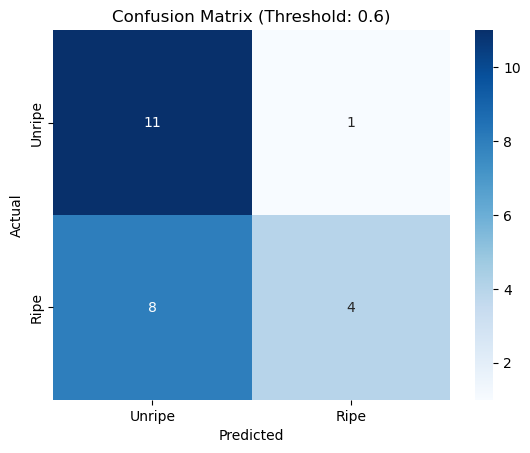

In [8]:
# 8. EXECUTION
df = build_dataset(RIPE_DIR, UNRIPE_DIR)
X_train, X_test, y_train, y_test, scaler = prepare_data(df)
model = create_model(input_dim=X_train.shape[1])
model, history = train_model(model, X_train, y_train)
evaluate_model(model, X_test, y_test, threshold=0.6)
model.save(MODEL_SAVE_PATH)

In [ ]:
# 9. PREDICT FROM NEW SAMPLES
SAMPLE_FOLDER = "samples/"

def predict_sample(file_path, model, scaler, threshold=0.6):
    features = extract_features(file_path)
    X = pd.DataFrame([features])
    X_scaled = scaler.transform(X)
    prob = model.predict(X_scaled)[0][0]
    label = "Ripe" if prob > threshold else "Unripe"
    print(f"{os.path.basename(file_path)} -> {label} (Prob: {prob:.2f})")

# Run prediction on all .wav files in samples/
for file in os.listdir(SAMPLE_FOLDER):
    if file.endswith(".wav"):
        predict_sample(os.path.join(SAMPLE_FOLDER, file), model, scaler, threshold=0.6)
        


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
ripe1.wav -> Unripe (Prob: 0.46)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
ripe10.wav -> Unripe (Prob: 0.56)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
ripe2.wav -> Unripe (Prob: 0.49)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
ripe3.wav -> Ripe (Prob: 0.60)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
ripe4.wav -> Unripe (Prob: 0.56)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
ripe5.wav -> Ripe (Prob: 0.66)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
ripe6.wav -> Unripe (Prob: 0.60)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
ripe7.wav -> Unripe (Prob: 0.53)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
ripe8.wav -> Unripe (Prob: 0.56)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
ripe9.wav -> Unripe (Prob: 0.53)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
unripe1.wav -> Unripe (Prob: 0.37)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
unripe10.wav -> Ripe (Prob: 0.64)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
unripe2.wav -> Unripe (Prob: 0.36)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
unripe3.wav -> Unripe (Prob: 0.40)
1/